In [1]:
# %load rbm.py
from __future__ import print_function
import numpy as np
#import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy as sp 
import sklearn
from imblearn.over_sampling import RandomOverSampler
import random 
from sklearn.preprocessing import MinMaxScaler
import time 
from sklearn import preprocessing, model_selection
from keras.models import Sequential 
from keras.layers import Dense 
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from keras.layers import Embedding, LSTM, SpatialDropout1D
#data = pd.read_csv('metadata.csv')
#data = shuffle(data)
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

class RBM:
  
  def __init__(self, num_visible, num_hidden):
    self.num_hidden = num_hidden
    self.num_visible = num_visible
    self.debug_print = True

    # Initialize a weight matrix, of dimensions (num_visible x num_hidden), using
    # a uniform distribution between -sqrt(6. / (num_hidden + num_visible))
    # and sqrt(6. / (num_hidden + num_visible)). One could vary the 
    # standard deviation by multiplying the interval with appropriate value.
    # Here we initialize the weights with mean 0 and standard deviation 0.1. 
    # Reference: Understanding the difficulty of training deep feedforward 
    # neural networks by Xavier Glorot and Yoshua Bengio
    np_rng = np.random.RandomState(1234)
    # RandomState exposes a number of methods for generating random numbers drawn from a variety of 
    #probability distributions.
    self.weights = np.asarray(np_rng.uniform(
			low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                       	high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                       	size=(num_visible, num_hidden)))


    # Insert weights for the bias units into the first row and first column.
    self.weights = np.insert(self.weights, 0, 0, axis = 0)
    self.weights = np.insert(self.weights, 0, 0, axis = 1)

  def train(self, data, max_epochs = 1000, learning_rate = 0.1):
    """
    Train the machine.

    Parameters
    ----------
    data: A matrix where each row is a training example consisting of the states of visible units.    
    """

    num_examples = data.shape[0]

    # Insert bias units of 1 into the first column.
    #data_input = pd.read_csv('cross mega.csv')
    #data = pd.data_input(np.array(data_input), columns=columns)
    #data['new'] = data.apply(func = random, axis = 1)
    #data_new = data_input.drop(['lcom'], axis = 1)
    data = np.insert(data, 0, 1, axis = 1)
    for epoch in range(max_epochs):      
      # Clamp to the data and sample from the hidden units. 
      # (This is the "positive CD phase", aka the reality phase.)
      pos_hidden_activations = np.dot(data, self.weights)      
      pos_hidden_probs = self._logistic(pos_hidden_activations)
      pos_hidden_probs[:,0] = 1 # Fix the bias unit.
      pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
      # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
      # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
      # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
      pos_associations = np.dot(data.T, pos_hidden_probs)

      # Reconstruct the visible units and sample again from the hidden units.
      # (This is the "negative CD phase", aka the daydreaming phase.)
      neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
      neg_visible_probs = self._logistic(neg_visible_activations)
      neg_visible_probs[:,0] = 1 # Fix the bias unit.
      neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
      neg_hidden_probs = self._logistic(neg_hidden_activations)
      # Note, again, that we're using the activation *probabilities* when computing associations, not the states 
      # themselves.
      neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

      # Update weights.
      self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

      error = np.sum((data - neg_visible_probs) ** 2)
      if self.debug_print:
        print("Epoch %s: error is %s" % (epoch, error))

  def run_visible(self, data):
    """
    Assuming the RBM has been trained (so that weights for the network have been learned),
    run the network on a set of visible units, to get a sample of the hidden units.
    
    Parameters
    ----------
    data: A matrix where each row consists of the states of the visible units.
    
    Returns
    -------
    hidden_states: A matrix where each row consists of the hidden units activated from the visible
    units in the data matrix passed in.
    """
    
    num_examples = data.shape[0]
    
    # Create a matrix, where each row is to be the hidden units (plus a bias unit)
    # sampled from a training example.
    hidden_states = np.ones((num_examples, self.num_hidden + 1))
    
    # Insert bias units of 1 into the first column of data.
    data = np.insert(data, 0, 1, axis = 1)

    # Calculate the activations of the hidden units.
    hidden_activations = np.dot(data, self.weights)
    # Calculate the probabilities of turning the hidden units on.
    hidden_probs = self._logistic(hidden_activations)
    # Turn the hidden units on with their specified probabilities.
    hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
    # Always fix the bias unit to 1.
    # hidden_states[:,0] = 1
  
    # Ignore the bias units.
    hidden_states = hidden_states[:,1:]
    return hidden_states
    
  # TODO: Remove the code duplication between this method and `run_visible`?
  def run_hidden(self, data):
    """
    Assuming the RBM has been trained (so that weights for the network have been learned),
    run the network on a set of hidden units, to get a sample of the visible units.

    Parameters
    ----------
    data: A matrix where each row consists of the states of the hidden units.

    Returns
    -------
    visible_states: A matrix where each row consists of the visible units activated from the hidden
    units in the data matrix passed in.
    """

    num_examples = data.shape[0]

    # Create a matrix, where each row is to be the visible units (plus a bias unit)
    # sampled from a training example.
    visible_states = np.ones((num_examples, self.num_visible + 1))

    # Insert bias units of 1 into the first column of data.
    data = np.insert(data, 0, 1, axis = 1)

    # Calculate the activations of the visible units.
    visible_activations = np.dot(data, self.weights.T)
    # Calculate the probabilities of turning the visible units on.
    visible_probs = self._logistic(visible_activations)
    # Turn the visible units on with their specified probabilities.
    visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)
    # Always fix the bias unit to 1.
    # visible_states[:,0] = 1

    # Ignore the bias units.
    visible_states = visible_states[:,1:]
    return visible_states
    
  def daydream(self, num_samples):
    """
    Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
    (where each step consists of updating all the hidden units, and then updating all of the visible units),
    taking a sample of the visible units at each step.
    Note that we only initialize the network *once*, so these samples are correlated.

    Returns
    -------
    samples: A matrix, where each row is a sample of the visible units produced while the network was
    daydreaming.
    """

    # Create a matrix, where each row is to be a sample of of the visible units 
    # (with an extra bias unit), initialized to all ones.
    samples = np.ones((num_samples, self.num_visible + 1))

    # Take the first sample from a uniform distribution.
    samples[0,1:] = np.random.rand(self.num_visible)

    # Start the alternating Gibbs sampling.
    # Note that we keep the hidden units binary states, but leave the
    # visible units as real probabilities. See section 3 of Hinton's
    # "A Practical Guide to Training Restricted Boltzmann Machines"
    # for more on why.
    for i in range(1, num_samples):
      visible = samples[i-1,:]

      # Calculate the activations of the hidden units.
      hidden_activations = np.dot(visible, self.weights)      
      # Calculate the probabilities of turning the hidden units on.
      hidden_probs = self._logistic(hidden_activations)
      # Turn the hidden units on with their specified probabilities.
      hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
      # Always fix the bias unit to 1.
      hidden_states[0] = 1

      # Recalculate the probabilities that the visible units are on.
      visible_activations = np.dot(hidden_states, self.weights.T)
      visible_probs = self._logistic(visible_activations)
      visible_states = visible_probs > np.random.rand(self.num_visible + 1)
      samples[i,:] = visible_states

    # Ignore the bias units (the first column), since they're always set to 1.
    return samples[:,1:]        
    
  def _logistic(self, x):
    return 1.0 / (1 + np.exp(-x))

#if __name__ == '__main__':
 # training_data = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],[1,1,1,0,0,0],[0,0,1,1,1,0], [0,0,1,1,0,0],[0,0,1,1,1,0]])
  #training_data = pd.read_csv('cross mega.csv')
  #r.train(training_data, max_epochs = 5000)
  #print(r.weights)
  #user = np.array([[0,0,0,1,1,0]])
  #print(r.run_visible(user))



C:\Users\SUSHANT\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\SUSHANT\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
C:\Users\SUSHANT\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as

In [2]:
data = pd.read_csv('cross mega.csv')
X = data.drop(['bug'], axis = 1)
X = np.array(X)
Y = data['bug']
Y.shape

(84646,)

In [3]:
from sklearn import preprocessing, model_selection

train_x, test_x, train_y, test_y = model_selection.train_test_split(X,Y,test_size = 0.2, random_state = 0)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
#input_dim = len(data.columns) - 1
train_x.shape

(67716, 1, 20)

In [4]:
train_y.shape

(67716,)

In [5]:
test_x.shape


(16930, 1, 20)

In [6]:
test_y.shape

(16930,)

In [7]:
r = RBM(num_visible = 20, num_hidden = 500)
train_x = np.reshape(train_x, (67716*1, 20)) 
test_x = np.reshape(test_x, (16930*1, 20)) 
r.train(train_x, max_epochs = 5)
print(r.weights)
  #user = np.array([[0,0,0,1,1,0]])


Epoch 0: error is 47539959475.019005
Epoch 1: error is 47523765278.58881
Epoch 2: error is 47523885442.93355
Epoch 3: error is 47523788942.04964
Epoch 4: error is 47523806128.9898
[[ 5.00000000e-02  1.35418042e-02 -1.00293275e-02 ...  1.50182897e-02
   1.85268099e-02 -6.34003796e-03]
 [ 2.68693647e+00  2.45260928e+00  2.28685593e+00 ...  2.56032567e+00
   2.57079873e+00  2.24927245e+00]
 [ 1.01289945e+00  9.18115355e-01  8.49075561e-01 ...  9.02581633e-01
   9.21270513e-01  8.53516875e-01]
 ...
 [ 1.45417242e+01  1.38692865e+01  1.23527614e+01 ...  1.37991722e+01
   1.38776274e+01  1.26923891e+01]
 [ 1.29288047e+00  1.20311634e+00  1.04781827e+00 ...  1.21287116e+00
   1.22213272e+00  1.06923994e+00]
 [ 2.20358351e-01  1.86524743e-01  1.39558534e-01 ...  1.76063941e-01
   1.92788820e-01  1.49536003e-01]]


In [8]:
print(r.run_visible(test_x))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [9]:
#print(r.run_visible(test_x))

In [10]:
from sklearn.neural_network import BernoulliRBM
import numpy as np
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#digits = datasets.load_digits()
#X = np.asarray(digits.data, 'float32')
#Y = digits.target
#X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling
data = pd.read_csv('cross mega.csv')
X = data.drop(['bug'], axis = 1)
X = np.array(X)
Y = data['bug']
#Y.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

logistic = linear_model.LogisticRegression(C=100)
rbm1 = BernoulliRBM(n_components=100, learning_rate=0.06, n_iter=1, verbose=1, random_state=101)
rbm2 = BernoulliRBM(n_components=80, learning_rate=0.06, n_iter=1, verbose=1, random_state=101)
rbm3 = BernoulliRBM(n_components=60, learning_rate=0.06, n_iter=1, verbose=1, random_state=101)
DBN3 = Pipeline(steps=[('rbm1', rbm1),('rbm2', rbm2), ('rbm3', rbm3), ('logistic', logistic)])

DBN3.fit(X_train, Y_train)

print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        DBN3.predict(X_test))))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -591147.55, time = 2.29s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -0.08, time = 2.11s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -0.14, time = 1.56s


C:\Users\SUSHANT\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     14181
           1       0.00      0.00      0.00      1796
           2       0.00      0.00      0.00       534
           3       0.00      0.00      0.00       183
           4       0.00      0.00      0.00        80
           5       0.00      0.00      0.00        51
           6       0.00      0.00      0.00        25
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.

C:\Users\SUSHANT\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        wmc       dit       noc       cbo       rfc      lcom        ca  \
0  0.026634  0.444444  0.003663  0.016279  0.072041  0.000484  0.002326   
1  0.033898  0.111111  0.001832  0.009302  0.054889  0.000817  0.004651   
2  0.007264  0.222222  0.000000  0.001163  0.015437  0.000000  0.000000   
3  0.029056  0.333333  0.000000  0.013953  0.063465  0.000534  0.000000   
4  0.014528  0.333333  0.000000  0.004651  0.036021  0.000017  0.000000   

         ce       npm     lcom3  ...  dam       moa       mfa       cam  \
0  0.090226  0.014409  0.362500  ...  1.0  0.006329  0.885057  0.232323   
1  0.030075  0.034582  0.417582  ...  1.0  0.000000  0.000000  0.307692   
2  0.007519  0.002882  0.000000  ...  1.0  0.006329  0.714286  0.666667   
3  0.090226  0.034582  0.429293  ...  1.0  0.006329  0.770833  0.458333   
4  0.030075  0.017291  0.350000  ...  1.0  0.000000  0.880952  0.416667   

         ic       cbm       amc    max_cc    avg_cc  bug  
0  0.500000  0.121212  0.009893  0.0119

In [26]:
ros = RandomOverSampler(random_state=0)
X_resampled, Y_resampled = ros.fit_resample(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled,
                                                    test_size=0.2,
                                                    random_state=0)
import numpy as np
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#3240, 20, 5255)
#input_dim = len(data.columns) - 1
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
X_trainnew = np.reshape(X_train, (2039097*1, 20)) 
X_testnew = np.reshape(X_test, (509775*1, 20)) 
#X_trainnew = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_testnew = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_trainnew.shape,X_testnew.shape)

C:\Users\SUSHANT\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(2039097, 20)
(2039097,)
(509775, 20)
(509775,)
(2039097, 20) (509775, 20)


In [38]:
#data = data.drop(['name', 'version', 'name'], axis =1)
data = pd.read_csv('cross mega.csv')
X = data.drop(['bug'], axis = 1)
X = np.array(X)
Y = data['bug']
Y.shape
scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
cols_to_norm = ['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom', 'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic', 'cbm', 'amc', 'max_cc', 'avg_cc']
data[cols_to_norm] = MinMaxScaler().fit_transform(data[cols_to_norm])
print(data.head())

        wmc       dit       noc       cbo       rfc      lcom        ca  \
0  0.026634  0.444444  0.003663  0.016279  0.072041  0.000484  0.002326   
1  0.033898  0.111111  0.001832  0.009302  0.054889  0.000817  0.004651   
2  0.007264  0.222222  0.000000  0.001163  0.015437  0.000000  0.000000   
3  0.029056  0.333333  0.000000  0.013953  0.063465  0.000534  0.000000   
4  0.014528  0.333333  0.000000  0.004651  0.036021  0.000017  0.000000   

         ce       npm     lcom3  ...  dam       moa       mfa       cam  \
0  0.090226  0.014409  0.362500  ...  1.0  0.006329  0.885057  0.232323   
1  0.030075  0.034582  0.417582  ...  1.0  0.000000  0.000000  0.307692   
2  0.007519  0.002882  0.000000  ...  1.0  0.006329  0.714286  0.666667   
3  0.090226  0.034582  0.429293  ...  1.0  0.006329  0.770833  0.458333   
4  0.030075  0.017291  0.350000  ...  1.0  0.000000  0.880952  0.416667   

         ic       cbm       amc    max_cc    avg_cc  bug  
0  0.500000  0.121212  0.009893  0.0119

C:\Users\SUSHANT\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train on 47401 samples, validate on 20315 samples
Epoch 1/1
16930/16930 [==============================] - 2s 89us/step
dict_keys(['val_loss', 'val_accuracy', 'val_mse', 'val_mae', 'val_mape', 'val_cosine', 'loss', 'accuracy', 'mse', 'mae', 'mape', 'cosine'])

accuracy: 83.76%

mse: 121.87%

mae: 30.68%

mape: 13295671.00%

cosine: 19.78%
dict_keys(['val_loss', 'val_accuracy', 'val_mse', 'val_mae', 'val_mape', 'val_cosine', 'loss', 'accuracy', 'mse', 'mae', 'mape', 'cosine'])


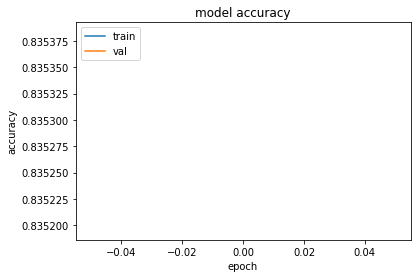

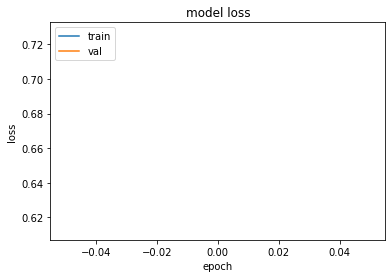

In [41]:
ros = RandomOverSampler(random_state=0)
X_resampled, Y_resampled = ros.fit_resample(X, Y)
train_x, test_x, train_y, test_y = model_selection.train_test_split(X,Y,test_size = 0.2, random_state = 0)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
input_dim = len(data.columns) - 1
model = Sequential()
#model.add(Embedding(1024, 1, input_length=20))
model.add(LSTM(70, input_shape = (1,20), dropout = 0.2, return_sequences=True))
model.add(LSTM(50, input_shape = (1,20), dropout = 0.2, return_sequences=True))
#model.add(LSTM(512, dropout = 0.3, return_sequences=True))
#model.add(LSTM(256, dropout = 0.4, return_sequences=True))
#model.add(LSTM(25, dropout = 0.2, return_sequences=True))
model.add(LSTM(40, dropout = 0.2, return_sequences=False))
#model.add(LSTM(16, input_shape=(1,20), dropout = 0.67))
#model.add(Dense(1, activation='softmax'))
#model.add(SpatialDropout1D(0.7))
#model.add(LSTM(64, dropout=0.7))
#model.add(LSTM(16, dropout=0.7, return_sequences=True))
#model.add(LSTM(8, dropout=0.7))
#model.add(Dense(10, input_dim = input_dim , activation = 'relu'))
#model.add(Dense(10, activation = 'relu'))
#model.add(Dense(8, activation = 'relu'))
#model.add(Dense(8, activation = 'relu'))
#model.add(Dense(6, activation = 'relu'))
#model.add(Dense(32, activation = 'softmax'))
model.add(Dense(63, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy','mse', 'mae', 'mape', 'cosine'] )
history = model.fit(train_x, train_y, validation_split = 0.3, epochs = 1, batch_size = 32)
score = model.evaluate(test_x, test_y)
print(history.history.keys())
model.test_on_batch(test_x, test_y)
model.metrics_names
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("\n%s: %.2f%%" % (model.metrics_names[2], score[2]*100))
print("\n%s: %.2f%%" % (model.metrics_names[3], score[3]*100))
print("\n%s: %.2f%%" % (model.metrics_names[4], score[4]))
print("\n%s: %.2f%%" % (model.metrics_names[5], score[5]*100))
print(history.history.keys())
#acc = history_dict['acc']
#val_acc = history_dict['val_acc']
#loss = history_dict['loss']
#val_loss = history_dict['val_loss']
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
DBN3 = Pipeline(steps=[('rbm1', rbm1),('rbm2', rbm2), ('rbm3', rbm3), ('LSTM', model)])

DBN3.fit(train_x, train_y)

print("LSTM using RBM features:\n%s\n" % (
   metrics.classification_report(
       test_y,
    DBN3.predict(test_x))))

ValueError: Found array with dim 3. Estimator expected <= 2.